<div style="background-color:red; padding:10px; border-radius:6px">
<h1 style="color:white"> <b>Challenge 4IM05</b> </h1>
</div>

### **Abdennour Kerboua** 
### For the _4IM05_ course at Télécom Paris

<div style="background-color:blue; padding:2px; border-radius:6px">
<h2 style="color:white"><strong>Importations</strong></h2>
</div>

<div style="background-color:#f0f0f0; padding:10px; border-radius:5px">
   <b style = "color:black">(a) Let's import some useful libraries and functions. </b>
</div>

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import sklearn
import os
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
from scipy.ndimage import label, binary_erosion, find_objects
from skimage.measure import regionprops, marching_cubes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skimage.feature import graycomatrix, graycoprops
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import cv2 as cv
from sklearn.metrics import confusion_matrix

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import tensorflow as tf
from scipy.stats import skew, kurtosis

# import tensorflow models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<div style="background-color:#f0f0f0; padding:10px; border-radius:5px">
   <b style = "color:black">(b) Let's import our data. </b>
</div>

In [3]:
def load_nii_files(base_path, first_subject=1, last_subject=100):
    """
    Charge les fichiers NIfTI (.nii) pour chaque sujet et les stocke dans une structure de données organisée.

    Args:
        base_path (str): Chemin du dossier contenant les sujets (ex: 'Dataset/Train/')
        subjects (int): Nombre de sujets à traiter

    Returns:
        dict: Un dictionnaire structuré contenant les images et segmentations pour chaque sujet.
    """
    data = {}

    for i in range(first_subject, last_subject + 1):
        subject_id = f"{i:03d}"  # Format "001", "002", etc.
        subject_path = os.path.join(base_path, subject_id)

        if not os.path.exists(subject_path):
            print(f"⚠️ Dossier {subject_path} introuvable, passage au suivant...")
            continue

        # Chemins des fichiers
        ed_path = os.path.join(subject_path, f"{subject_id}_ED.nii")
        es_path = os.path.join(subject_path, f"{subject_id}_ES.nii")
        ed_seg_path = os.path.join(subject_path, f"{subject_id}_ED_seg.nii")
        es_seg_path = os.path.join(subject_path, f"{subject_id}_ES_seg.nii")

        try:
            # Chargement des fichiers NIfTI
            ed_img = nib.load(ed_path).get_fdata() if os.path.exists(ed_path) else None
            es_img = nib.load(es_path).get_fdata() if os.path.exists(es_path) else None
            ed_seg = nib.load(ed_seg_path).get_fdata() if os.path.exists(ed_seg_path) else None
            es_seg = nib.load(es_seg_path).get_fdata() if os.path.exists(es_seg_path) else None
            size = np.prod(nib.load(ed_path).header.get_zooms())
            # Stockage dans un dictionnaire
            data[subject_id] = {
                "ED": ed_img,      # Image en début de systole
                "ES": es_img,      # Image en fin de systole
                "ED_seg": ed_seg,  # Segmentation début systole
                "ES_seg": es_seg,   # Segmentation fin systole
                "size": size        # Volume d'un pixel
            }

        except Exception as e:
            print(f"Erreur lors du chargement des fichiers pour le sujet {subject_id}: {e}")

    return data

base_path_train = 'Dataset/Train/'
data_train = load_nii_files(base_path_train, 1,100)
print(f"Loading of training data for {len(data_train)} subjects.")

base_path_test = 'Dataset/Test/'
data_test = load_nii_files(base_path_test, 101,150)
print(f"Loading of test data for {len(data_test)} subjects.")

Loading of training data for 100 subjects.
Loading of test data for 50 subjects.


Let's try to segment the left ventricle using myocarde segmentation.

In [ ]:
def segment_vg_contour(segment):
    mask = (segment==2)
    mask = np.ascontiguousarray(mask)
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    mask_vg = np.zeros_like(mask, dtype=np.uint8)
    cv.drawContours(mask_vg, [largest_contour], -1, color=1, thickness=cv.FILLED)
    return mask_vg - mask

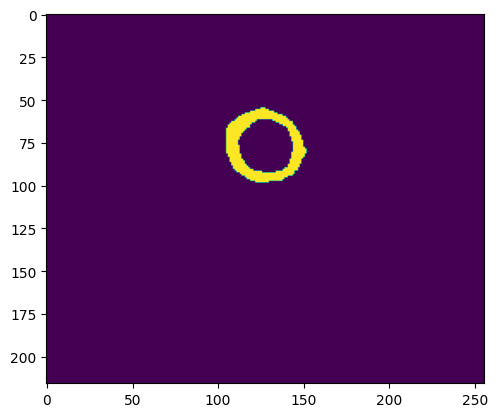

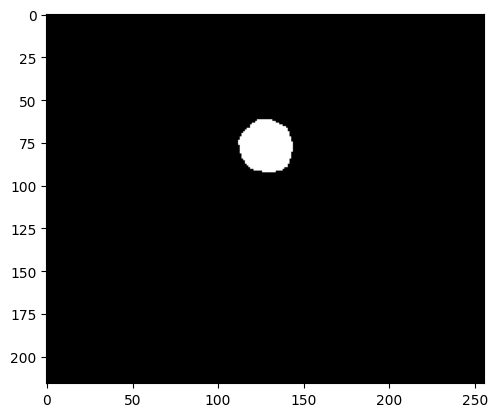

In [5]:
seg_vg = segment_vg_contour(data_test['101']['ED_seg'][:,:,1])
plt.imshow(data_test['101']['ED_seg'][:,:,1]==2)
plt.figure()
plt.imshow(seg_vg, cmap='gray')

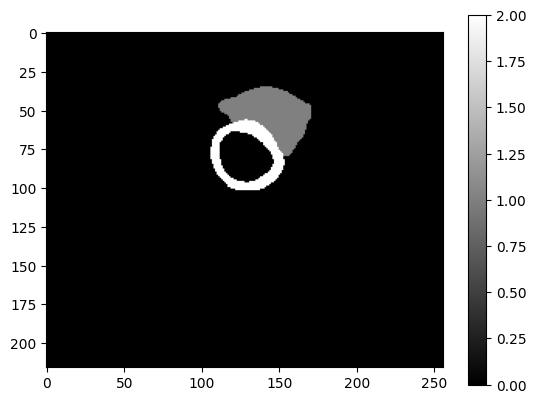

In [6]:
### Before additional segmentation
plt.figure()
plt.imshow(data_test["101"]["ED_seg"][:,:,2], cmap='gray')
plt.colorbar()

In [ ]:
def completion_seg(data):
    subjects = list(data.keys())
    for subject_id in subjects:
        for time in ['ED', 'ES']:
            segs = data[subject_id][f"{time}_seg"]
            for i in range(1,segs.shape[2]):
                seg = segs[:,:,i]
                if np.sum(seg==2) == 0:
                    continue
                seg_vg = segment_vg_contour(seg)
                seg_vg_indices = np.where(seg_vg==1)
                seg[seg_vg_indices] = 3
                data[subject_id][f"{time}_seg"][:,:,i] = seg
    return
        

In [ ]:
### Execute the completion of the segmentation
completion_seg(data_test)

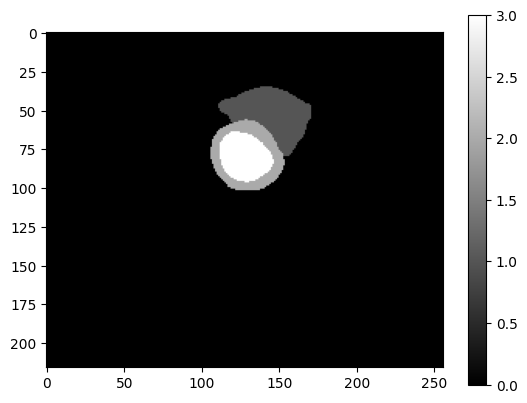

In [9]:
### After additional segmentation
plt.figure()
plt.imshow(data_test["101"]["ED_seg"][:,:,2], cmap='gray')
plt.colorbar()

In [10]:
metadata_train = pd.read_csv('Dataset/metaDataTrain.csv')
metadata_test = pd.read_csv('Dataset/metaDataTest.csv')
metadata_test.head()

,Id,Height,Weight
0,101,170.0,70.0
1,102,162.0,60.0
2,103,185.0,104.0
3,104,158.0,56.0
4,105,164.0,64.0


In [11]:
y_train = metadata_train['Category'].values

<div style="background-color:blue; padding:2px; border-radius:6px">
<h2 style="color:white"><strong>Features extraction</strong></h2>
</div>

Volumetric and ejection fractions features using ventricule segmentation.

In [12]:
def compute_volumetric_features(data):
    subjects = list(data.keys())
    n_subjects = len(subjects)
    n_features = 12  # Volumes (6) + Ejection Fractions (2) + Ratios (4)
    
    features_array = np.zeros((n_subjects, n_features))

    for i, subject_id in enumerate(subjects):
        ed_seg = data[subject_id]["ED_seg"]  # ED segmentation (N,M,10)
        es_seg = data[subject_id]["ES_seg"]  # ES segmentation (N,M,10)
        size = data[subject_id]["size"]
        # Compute volumes: count the number of voxels for each label
        lvv_ed = np.sum(ed_seg == 3)*size  # Left ventricle cavity at ED
        lvv_es = np.sum(es_seg == 3)*size  # Left ventricle cavity at ES
        rvv_ed = np.sum(ed_seg == 1)*size  # Right ventricle cavity at ED
        rvv_es = np.sum(es_seg == 1)*size  # Right ventricle cavity at ES
        mv_ed = np.sum(ed_seg == 2)*size   # Myocardium at ED
        mv_es = np.sum(es_seg == 2)*size   # Myocardium at ES

        # Compute Ejection Fraction (EF) for left and right ventricles
        lvef = ((lvv_ed - lvv_es) / lvv_ed) * 100 if lvv_ed > 0 else 0
        rvef = ((rvv_ed - rvv_es) / rvv_ed) * 100 if rvv_ed > 0 else 0
        # Compute RV/LV ratio at ED and ES
        rv_lv_ratio_ed = rvv_ed / lvv_ed if lvv_ed > 0 else 0
        rv_lv_ratio_es = rvv_es / lvv_es if lvv_es > 0 else 0
        # Compute RV/Myocardium ratio at ED and ES
        rv_myocardium_ratio_ed = rvv_ed / mv_ed if mv_ed > 0 else 0
        rv_myocardium_ratio_es = rvv_es / mv_es if mv_es > 0 else 0
    
        # Store features in the array
        features_array[i, :] = [lvv_ed, lvv_es, rvv_ed, rvv_es, mv_ed, mv_es, lvef, rvef, rv_lv_ratio_ed, rv_lv_ratio_es, rv_myocardium_ratio_ed, rv_myocardium_ratio_es]

    return features_array

Radiometric features computed using intensities of pixels (mean, std, skew...).

In [13]:
def compute_radiometric_features(data):
    """
    Calcule les caractéristiques radiométriques des IRM cardiaques.
    
    :param data: Dictionnaire contenant les segmentations des patients.
    :return: Un tableau de features radiométriques.
    """
    
    subjects = list(data.keys())
    n_subjects = len(subjects)
    n_features = 12  # 2 features * 3 régions * 2 phases (ED, ES)
    
    features_array = np.zeros((n_subjects, n_features))

    for i, subject_id in enumerate(subjects):
        ed_seg = data[subject_id]["ED_seg"]  # Segmentation ED (N,M,10)
        es_seg = data[subject_id]["ES_seg"]  # Segmentation ES (N,M,10)
        ed_img = data[subject_id]["ED"]    # IRM ED (N,M,10)
        es_img = data[subject_id]["ES"]    # IRM ES (N,M,10)

        # Fonction pour extraire les stats d'intensité d'une région donnée
        def extract_intensity_features(image, mask):
            values = image[mask > 0]  # Intensités dans la région d'intérêt
            if len(values) == 0:
                return [0, 0, 0, 0]  # Si la région est vide
            return [skew(values), kurtosis(values)]
        
        # Extraction des features pour chaque région et phase
        lv_ed_features = extract_intensity_features(ed_img, ed_seg == 3)  # LV ED
        lv_es_features = extract_intensity_features(es_img, es_seg == 3)  # LV ES
        rv_ed_features = extract_intensity_features(ed_img, ed_seg == 1)  # RV ED
        rv_es_features = extract_intensity_features(es_img, es_seg == 1)  # RV ES
        myo_ed_features = extract_intensity_features(ed_img, ed_seg == 2)  # Myo ED
        myo_es_features = extract_intensity_features(es_img, es_seg == 2)  # Myo ES
    
        # Stockage des features dans le tableau
        features_array[i, :] = lv_ed_features + lv_es_features + rv_ed_features + rv_es_features + myo_ed_features + myo_es_features

    return features_array

Mensuration features : BMI, BSA computed using height and weight of the subject.

In [14]:
def mensuration_features(data):
    subjects = data['Id'].values
    n_subjects = len(subjects)
    n_features = 4
    height_array = data['Height'].values
    weight_array = data['Weight'].values
    features_array = np.zeros((n_subjects, n_features))
    for i, subject_id in enumerate(subjects):
        bmi = weight_array[i]/(height_array[i]/100)**2
        bsa = 0.007184 * (height_array[i]**0.725) * (weight_array[i]**0.425)  # Body Surface Area
        #bai = (weight_array[i] / (height_array[i] / 100)**1.5) - 18  # Body Adiposity Index
        features_array[i, :] = [height_array[i], weight_array[i], bmi, bsa]
        
    return features_array

We compute and concatenate the features.

In [15]:
# Features extraction
volumetric_features_train = compute_volumetric_features(data_train)

volumetric_features_test = compute_volumetric_features(data_test)

radiometric_features_train = compute_radiometric_features(data_train)

radiometric_features_test = compute_radiometric_features(data_test)

mensuration_features_train = mensuration_features(metadata_train)

mensuration_features_test = mensuration_features(metadata_test)

# Combine features
X_train = np.concatenate((volumetric_features_train, radiometric_features_train , mensuration_features_train), axis=1)
X_test = np.concatenate((volumetric_features_test, radiometric_features_test , mensuration_features_test), axis=1)

In [ ]:
print(f"#Training subjects/#Training features: {X_train.shape} | #Testing subjects/#Features de test: {X_test.shape}")

Features d'entraînement: (100, 28) | Features de test: (50, 28)


Let's shuffle the data that is obviously well ordered, to avoid any bias.

In [17]:
N = len(y_train)
indices = np.random.permutation(N)
X_train = X_train[indices]
y_train = y_train[indices]

In [18]:
print(y_train)

[0 2 1 4 0 4 4 1 3 2 4 4 1 2 2 3 0 4 1 2 4 4 0 1 1 3 2 0 1 1 1 0 0 3 0 0 3
 4 1 3 1 0 1 3 1 2 1 3 4 3 3 0 0 0 2 0 3 4 4 0 3 2 2 2 1 1 3 2 4 1 2 3 4 4
 1 3 3 4 2 2 2 2 0 2 4 4 2 3 0 3 4 4 2 0 3 1 0 0 3 1]


<div style="background-color:blue; padding:2px; border-radius:6px">
<h2 style="color:white"><strong>Let's try ML solutions !</strong></h2>
</div>

Let's estimate the best hyperparameters for various ML models.

In [134]:
#Linear SVM
lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(lsvm, p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Linear SVM ")
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

# Non-linear SVM
nlsvm = make_pipeline(StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(nlsvm, p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)

print("Non linear SVM")
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

# KNN
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
print("KNN")
#print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))

# LDA
lda = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=X_train,y= y_train,cv=5)
print("LDA")
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# QDA
qda = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=X_train, y=y_train,cv=5)
print("QDA")
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Decision Trees 
tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=0))
p_grid_tree = {'decisiontreeclassifier__min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'decisiontreeclassifier__min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid_tree = GridSearchCV(estimator=tree, param_grid=p_grid_tree, scoring="accuracy", cv=5)
grid_tree.fit(X_train, y_train)
print("Tree")
print("Best training Score: {}".format(grid_tree.best_score_))
print("Best training params: {}".format(grid_tree.best_params_))

#Bagging
best_params=grid_tree.best_params_
Tree = DecisionTreeClassifier(min_samples_leaf=best_params['decisiontreeclassifier__min_samples_leaf'],min_samples_split=best_params['decisiontreeclassifier__min_samples_split'], random_state=0)
bagging=make_pipeline(StandardScaler(),BaggingClassifier(random_state=0))
p_grid_bagging = {'baggingclassifier__n_estimators': [50,60,70,80,90,100,110,120,130,140,150]}      
grid_bagging = GridSearchCV(estimator=bagging, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Bagging Tree")
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))

#Random Forrest
RF=make_pipeline(StandardScaler(),RandomForestClassifier(random_state=0))
p_grid_RF = {'randomforestclassifier__n_estimators': [50,60,70,80,90,100,110,120,130,140,150], 'randomforestclassifier__min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'randomforestclassifier__max_features': ['sqrt','log2']}   
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Random Forrest")
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Linear SVM 
Best training Score: 0.8800000000000001
Best training params: {'linearsvc__C': 0.1}
Non linear SVM
Best training Score: 0.95
Best training params: {'svc__C': 1, 'svc__gamma': 0.1}
KNN
Best training Score: 0.89
Best training params: {'kneighborsclassifier__n_neighbors': 5}
LDA
 Average and std CV score : 0.8699999999999999 +- 0.06782329983125268
QDA
 Average and std CV score : 0.6300000000000001 +- 0.11224972160321822


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



Tree
Best training Score: 0.8699999999999999
Best training params: {'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__min_samples_split': 2}
Bagging Tree
Best Validation Score: 0.9199999999999999
Best params: {'baggingclassifier__n_estimators': 120}
Random Forrest
Best Validation Score: 0.9400000000000001
Best params: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 50}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



In [ ]:
### Logistic Regression
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
p_grid_log_reg = {'logisticregression__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_log_reg = GridSearchCV(log_reg, p_grid_log_reg, scoring="accuracy", cv=5)
grid_log_reg.fit(X_train, y_train)
print("Logistic Regression")
print("Best training Score: {}".format(grid_log_reg.best_score_))
print("Best training params: {}".format(grid_log_reg.best_params_))

Logistic Regression
Best training Score: 0.9200000000000002
Best training params: {'logisticregression__C': 0.1}


Let's predict test labels using the best paremeters estimated using cross-validation.

In [164]:
lda = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())
lda.fit(X_train, y_train)
print("LDA")
y_pred_lda = lda.predict(X_test)
print(y_pred_lda)

log_reg = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, max_iter=1000))
log_reg.fit(X_train, y_train)
print("Logistic Regression")
y_pred_log_reg = log_reg.predict(X_test)
print(y_pred_log_reg)

lsvm = make_pipeline(StandardScaler(), LinearSVC(C=0.1)) 
lsvm.fit(X_train, y_train)
print("LSVM")
y_pred_lvsm = lsvm.predict(X_test)
print(y_pred_lvsm)

nlsvm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=0.1)) 
nlsvm.fit(X_train, y_train)
print("NLSVM")
y_pred_nlsvm = nlsvm.predict(X_test)
print(y_pred_nlsvm)

neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
neigh.fit(X_train, y_train)
print("KNN")
y_pred_KNN = neigh.predict(X_test)
print(y_pred_KNN)

tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(min_samples_leaf= 3, min_samples_split= 2, random_state=0))
tree.fit(X_train, y_train)
print("TREE")
y_pred_tree = tree.predict(X_test)
print(y_pred_tree)

bagging=make_pipeline(StandardScaler(),BaggingClassifier(random_state=0, n_estimators=120))
bagging.fit(X_train,y_train)
print("BAGGING")
y_pred_bagging = bagging.predict(X_test)
print(y_pred_bagging)

RF=make_pipeline(StandardScaler(),RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf= 3, n_estimators=50))
RF.fit(X_train, y_train)
print("RF")
y_pred_RF = RF.predict(X_test)
print(y_pred_RF)

LDA
[0 4 0 0 1 1 4 2 1 0 3 2 1 0 3 2 4 4 4 1 0 1 0 1 3 2 4 0 3 0 0 1 2 3 1 3 3
 1 0 3 1 1 3 0 1 4 2 0 1 4]
Logistic Regression
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 0 1 2 3 2 3 3
 2 4 3 1 1 3 0 1 4 2 4 1 4]
LSVM
[3 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 2 0 1 4 2 3 2 4 0 3 3 0 1 2 3 2 3 3
 2 4 3 1 1 3 0 1 4 2 4 1 4]
NLSVM
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 4 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 3 1 2 3 1 3 3
 2 0 3 1 1 3 0 1 4 2 4 1 4]
KNN
[0 4 0 0 2 1 4 2 1 0 3 1 1 4 3 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 0 1 2 3 1 3 3
 2 0 3 1 1 3 0 1 4 2 4 1 4]
TREE
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 1 0 1 4 1 3 2 4 0 3 0 0 2 2 3 2 3 0
 2 4 3 1 1 3 0 1 4 2 4 1 4]
BAGGING
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 1 0 1 4 1 3 2 4 0 3 0 0 1 2 3 1 3 3
 2 4 3 1 1 3 0 1 4 2 4 1 4]
RF
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 0 1 2 3 1 3 4
 2 4 3 1 1 3 0 1 4 2 4 1 4]


Confusion matrix for the training/test prediction.

Normalized confusion matrix
[[0.86363636 0.04545455 0.         0.04545455 0.04545455]
 [0.         0.95       0.05       0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.05       0.         0.         0.95       0.        ]
 [0.         0.         0.         0.         1.        ]]


<function matplotlib.pyplot.show(close=None, block=None)>

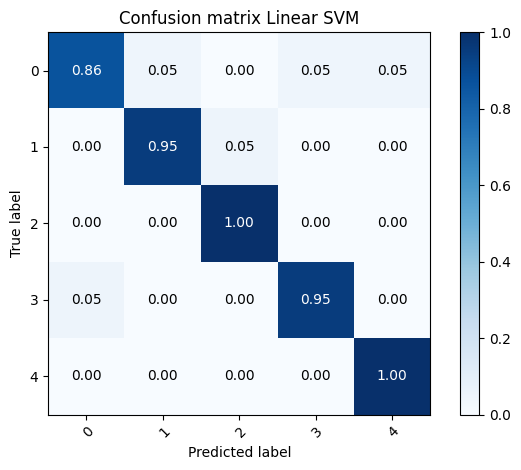

In [147]:
# Compute confusion matrix lsvm
confusion_matrix_lsvm = confusion_matrix(lsvm.predict(X_train),y_train)

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix_lsvm, classes=['0', '1','2','3','4'], title='Confusion matrix Linear SVM', normalize=True)
plt.show

Normalized confusion matrix
[[0.90909091 0.         0.         0.04545455 0.04545455]
 [0.         0.95       0.05       0.         0.        ]
 [0.         0.05       0.95       0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


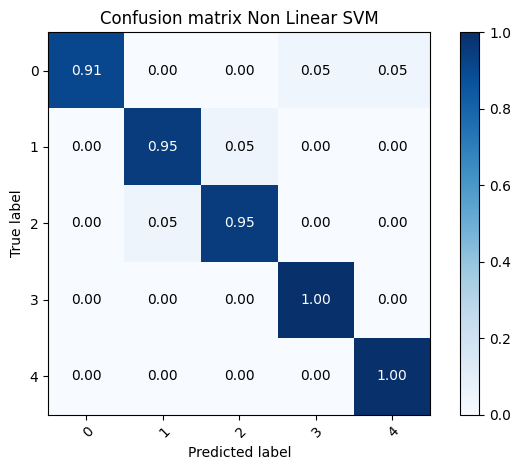

In [148]:
# Compute confusion matrix nlsvm
confusion_matrix_nlsvm = confusion_matrix(nlsvm.predict(X_train),y_train)

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix_nlsvm, classes=['0', '1','2','3','4'], title='Confusion matrix Non Linear SVM', normalize=True)
plt.show()


Normalized confusion matrix
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


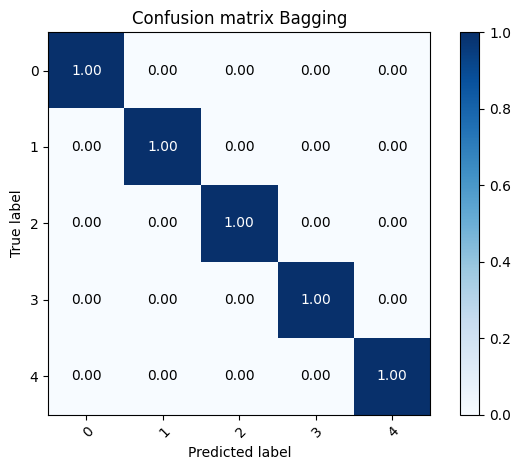

In [149]:
# Compute confusion matrix bagging
confusion_matrix_bagging = confusion_matrix(bagging.predict(X_train),y_train)

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix_bagging, classes=['0', '1','2','3','4'], title='Confusion matrix Bagging', normalize=True)
plt.show()

Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   0.95 0.05 0.   0.  ]
 [0.   0.05 0.95 0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


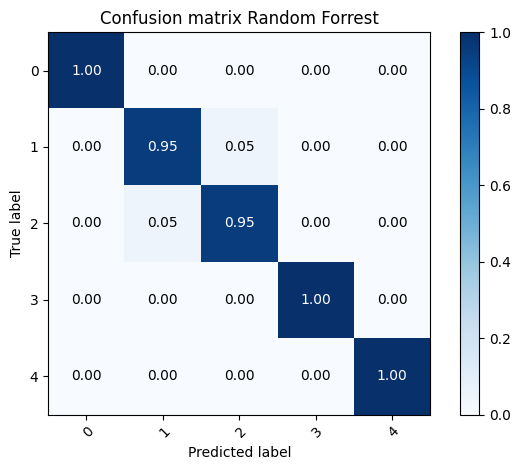

In [150]:
# Compute confusion matrix RF
confusion_matrix_RF = confusion_matrix(RF.predict(X_train),y_train)

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix_RF, classes=['0', '1','2','3','4'], title='Confusion matrix Random Forrest', normalize=True)
plt.show()

We use here cross-validation to get the best model trained on the training subjects dividing it between Train/Validation sets.

In [19]:
# Let's try cross-validation
cv_score = cross_validate(make_pipeline(StandardScaler(), LinearSVC(C=0.1)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("Linear SVM")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_svm = estimators[np.argmax(cv_score['test_score'])]
best_svm.fit(X_train, y_train)
y_pred_svm = best_svm.predict(X_test)
print(y_pred_svm)

cv_score = cross_validate(make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=0.1)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("Non Linear SVM")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_nsvm = estimators[np.argmax(cv_score['test_score'])]
best_nsvm.fit(X_train, y_train)
y_pred_nsvm = best_nsvm.predict(X_test)
print(y_pred_nsvm)

cv_score = cross_validate(make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("KNN")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_neigh = estimators[np.argmax(cv_score['test_score'])]
best_neigh.fit(X_train, y_train)
y_pred_neigh = best_neigh.predict(X_test)
print(y_pred_neigh)

cv_score = cross_validate(make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_leaf= 3, min_samples_split= 2, random_state=0)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("Tree")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_tree = estimators[np.argmax(cv_score['test_score'])]
best_tree.fit(X_train, y_train)
y_pred_tree = best_tree.predict(X_test)
print(y_pred_tree)

cv_score = cross_validate(make_pipeline(StandardScaler(), BaggingClassifier(random_state=0, n_estimators=120)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("Bagging")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_bag = estimators[np.argmax(cv_score['test_score'])]
best_bag.fit(X_train, y_train)
y_pred_bag = best_bag.predict(X_test)
print(y_pred_bag)

cv_score = cross_validate(make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf= 3, n_estimators=50)), X_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)
print("Random Forrest")
print("Average training score: ", cv_score['train_score'].mean())
print("Average validation score: ", cv_score['test_score'].mean())
estimators = cv_score['estimator']
best_rf = estimators[np.argmax(cv_score['test_score'])]
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
print(y_pred_rf)

Linear SVM
Average training score:  0.9875
Average validation score:  0.85
[0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 1 0 1 4 1 3 2 4 0 3 0 3 1 2 3 2 3 3
 1 4 3 1 3 3 0 1 4 2 4 1 4]
Non Linear SVM
Average training score:  1.0
Average validation score:  0.8200000000000001
[0 4 0 0 2 3 4 2 1 0 3 1 1 4 2 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 3 3 2 3 1 3 3
 2 4 3 1 3 3 0 1 4 2 4 1 4]
KNN
Average training score:  0.8425
Average validation score:  0.72
[0 4 0 0 1 1 4 1 0 0 0 1 1 4 3 2 4 4 4 1 0 0 0 1 3 2 4 0 3 0 0 1 2 0 1 3 0
 2 0 3 1 1 1 0 1 4 2 4 1 4]
Tree
Average training score:  0.9674999999999999
Average validation score:  0.85
[0 4 0 0 2 1 4 2 1 0 0 2 1 4 3 2 4 4 4 1 0 1 4 1 3 2 4 0 3 0 0 2 2 3 2 3 3
 2 4 3 1 1 3 0 1 4 2 4 1 4]
Bagging
Average training score:  1.0
Average validation score:  0.9199999999999999
[0 4 0 0 2 1 4 2 1 0 0 2 1 4 3 2 4 4 4 1 0 1 4 1 3 2 4 0 3 0 0 1 2 3 2 3 0
 2 4 3 1 1 3 0 1 4 2 4 1 4]
Random Forrest
Average training score:  0.9924999999999999
Average validation score:  0.

We use a majority vote strategy to get the best prediction for the test subjects.

In [20]:
y_pred = np.array([y_pred_svm, y_pred_nsvm, y_pred_bag, y_pred_rf, y_pred_neigh, y_pred_tree])
print(y_pred.shape)
final_predictions = np.array([Counter(row).most_common(1)[0][0] for row in y_pred.T])

(6, 50)


In [ ]:
print(final_predictions)

# Save predictions
# Create a DataFrame with Id and predictions
predictions_df = pd.DataFrame({
    'Id': range(101, 151),
    'Prediction': final_predictions
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

In [25]:
# Create a DataFrame with Id and predictions
predictions_df = pd.DataFrame({
    'Id': range(101, 151),
    'Prediction': y_pred_rf
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions_rf.csv', index=False)

<div style="background-color:blue; padding:10px; border-radius:5px">
    <h2 style="color:white"><strong>Let's try DL solutions !</strong></h2>
</div>

Let's train 50 Multi-Layer Perceptron (MLP) and make a majority vote to get a prediction. It shouldn't be better than above ML models.

In [170]:
#Average 50 MLP
y_pred_mlp=np.zeros(50)
n_hidden=32
n_input=X_train.shape[1]
n_epochs = 200
batch_size = 32
#Hot-encoding
y_train_hotencoding=tf.keras.utils.to_categorical(y_train)

for i in range (50):
  model_mlp = Sequential()   
  model_mlp.add(Dense(n_hidden,input_dim=n_input, activation="relu"))
  model_mlp.add( BatchNormalization())
  model_mlp.add(Dense(n_hidden,activation="relu"))
  model_mlp.add( BatchNormalization())
  model_mlp.add(Dense(n_hidden,activation="relu"))
  model_mlp.add( BatchNormalization())
  model_mlp.add(Dense(n_hidden,activation="relu"))
  model_mlp.add( BatchNormalization())
  model_mlp.add(Dense(5, activation="softmax"))

  # create the loss and optimiser
  learning_rate = 5e-4
  model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"]) 

  # Run optimisation algorithm
  model_mlp.fit(X_train, y_train_hotencoding, epochs=n_epochs, batch_size=batch_size) 
  y_pred_mlp=y_pred_mlp + np.argmax(model_mlp.predict(X_test), axis=1)
  print(i)

y_pred_mlp=(y_pred_mlp/50)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1136 - loss: 2.7037
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1854 - loss: 2.3003 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2462 - loss: 2.0915 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2474 - loss: 1.9608 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2993 - loss: 1.8799 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3820 - loss: 1.6317 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3379 - loss: 1.6365 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4321 - loss: 1.5075 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5267 - loss: 1.3050 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5123 - loss: 1.2455 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5676 - loss: 1.0640 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5512 - loss

In [175]:
y_pred_mlp=np.round(y_pred_mlp)
print(y_pred_mlp)

# Save predictions
# Create a DataFrame with Id and predictions
predictions_df_mlp = pd.DataFrame({
    'Id': range(101, 151),
    'Prediction': y_pred_mlp
})

# Save the DataFrame to a CSV file
predictions_df_mlp.to_csv('predictions_mlp.csv', index=False)


[0. 4. 0. 0. 2. 1. 4. 2. 1. 0. 1. 2. 1. 4. 3. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 1. 3. 2. 2. 3. 3. 1. 1. 3. 0. 1. 4. 2. 4.
 1. 4.]
